In [1]:
import numpy as np
from astropy.io import fits
import requests
from astroquery.mast import Catalogs
import zipfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline

urlroot = "https://mast.stsci.edu/tesscut/api/v0.1"

In [2]:
ticid = 200588708

starName = "TIC " + str(ticid)
radSearch = 5 / 60 # radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
Ra = catalogData[0]['ra']
Dec = catalogData[0]['dec']

# Print out the first five rows in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

    ID      Tmag   Jmag         ra              dec        objType
--------- ------- ------ ---------------- ---------------- -------
200588708 14.7443 12.441 83.2780622977873 11.7793957454409    STAR
716186275 14.3471     -- 83.2779519403047 11.7802798859033    STAR
716186273 18.2487     -- 83.2763860935861 11.7775970614952    STAR
200588707 16.3592 15.268 83.2748866747712 11.7762548869047    STAR
200588711 16.6032 15.531  83.273580839335 11.7827304115394    STAR


In [3]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 14

# Make it a list of Ra, Dec pairs of the bright ones. So this is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

12

In [4]:
url = urlroot + "/sector"

myparams = {"ra":Ra, "dec":Dec, "radius":"0m"}

requestData = requests.get(url = url, params = myparams)

print(requestData.headers.get('content-type'))

application/json; charset=UTF-8


In [5]:
sectors = requestData.json()['results']
print(sectors)

[{'sectorName': 'tess-s0006-1-4', 'sector': '0006', 'camera': '1', 'ccd': '4'}]


In [6]:
myparams = {"ra":Ra, "dec":Dec, "x":35, "y":45, 
           "units":"px", "sector":"All"}

url = urlroot + "/astrocut"

r = requests.get(url = url, params = myparams)

print(r)
print(r.headers.get('content-type'))

<Response [200]>
application/zip


In [7]:
open('astrocut.zip', 'wb').write(r.content)

31398034

In [8]:
zipRef = zipfile.ZipFile('astrocut.zip','r')
zipRef.extractall('.')
zipRef.close()

# Get list of cuotut names
cutoutnames = zipRef.namelist()
print(cutoutnames)

['tess-s0006-1-4_83.278062_11.779396_35x45_astrocut.fits']


In [9]:
file1 = cutoutnames[0]
fits.info(file1)

Filename: tess-s0006-1-4_83.278062_11.779396_35x45_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  PIXELS        1 BinTableHDU    279   993R x 12C   [D, E, J, 1575J, 1575E, 1575E, 1575E, 1575E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       147   (35, 45)   int32   


In [10]:
hdu1 = fits.open(file1)
hdu1[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '1575J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(35, 45)'
    name = 'FLUX'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'FLUX_ERR'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'FLUX_BKG'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'FLUX_BKG_ERR'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'FFI_FILE'; format = '38A'; unit = 'pixel'
)

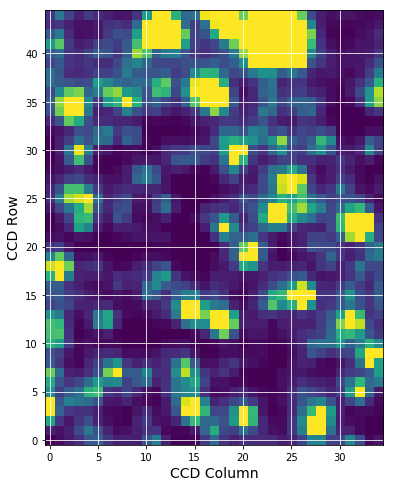

In [11]:
firstImage = hdu1[1].data['FLUX'][0]
fig = plt.figure(figsize=(8,8))
plt.imshow(firstImage, origin = 'lower', cmap = plt.cm.viridis, \
           vmax = np.percentile(firstImage,92), vmin = np.percentile(firstImage,5))
plt.xlabel('CCD Column', fontsize = 14)
plt.ylabel('CCD Row', fontsize = 14)
plt.grid(axis = 'both', color = 'white', ls = 'solid')

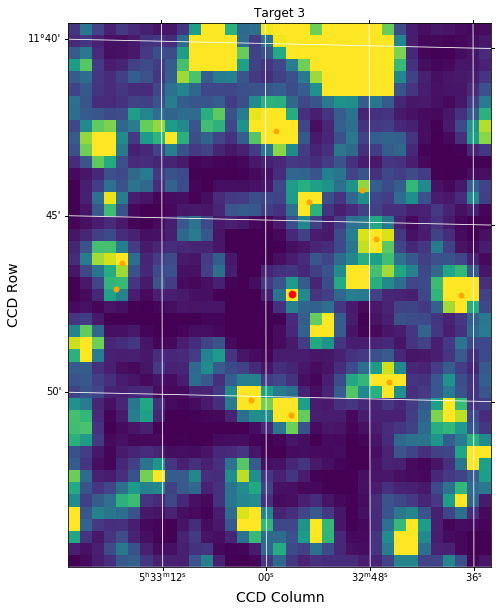

In [12]:
wcs = WCS(hdu1[2].header)

fig = plt.figure(figsize = (10,10))
fig.add_subplot(111, projection = wcs)
plt.imshow(firstImage, origin = 'lower', cmap = plt.cm.viridis, vmax = np.percentile(firstImage,92),\
           vmin = np.percentile(firstImage,5))

plt.xlabel('CCD Column', fontsize = 14)
plt.ylabel('CCD Row', fontsize = 14)
plt.grid(axis = 'both', color = 'white', ls = 'solid')

starLoc = wcs.all_world2pix([[Ra,Dec]],0)  #Second is origin
plt.scatter(starLoc[0,0], starLoc[0,1], s = 45, color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:], 0)
plt.scatter(nearbyLoc[1:,0], nearbyLoc[1:,1], s = 25, color = 'orange')
plt.title("Target 3")
plt.show()

In [16]:
# import the packages we need
import os
import numpy as np
import requests
import k2flix
%matplotlib inline
import matplotlib.pyplot as plt

# astroquery
from astroquery.mast import Tesscut
from astroquery.mast import Catalogs

# Astropy
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm

from reproject import reproject_interp

from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual

In [42]:
# select a target and cutout size in pixels
ra, dec = 83.27803, 11.779415
target = '{0}, {1}'.format(ra, dec)
x = y = 11

# set local file path to current working directory
path = os.path.abspath(os.path.curdir)

In [43]:
# create a sky coordinate object
cutout_coords = SkyCoord(ra, dec, unit="deg")
    
# download the files and get the list of local paths
try:
    table = Tesscut.download_cutouts(cutout_coords, size=x, path=path)
except Exception as e:
    print('Error: Could not download cutouts: {0}'.format(e))
else:
    print(table)
    files = table['Local Path']

Inflating...
                                          Local Path                                          
----------------------------------------------------------------------------------------------
/Users/ewarrick/Data Work/Class II SB2s/tess-s0006-1-4_83.278030_11.779415_11x11_astrocut.fits


In [44]:
# grab the first file in the list
filename = files[0]

# create the TargetPixelFile instance
tpf = k2flix.TargetPixelFile(filename)

# get number of pixels in flux array 
n_pix = tpf.flux().shape[0]

# compute field of view in degrees
res = 21.0 * (u.arcsec/u.pixel)
area = res * (n_pix * u.pixel)
d = area.to(u.degree)
fov = d.value 

# compute the wcs of the image
wcs = WCS(tpf.hdulist['APERTURE'].header)

# print some info
print('filename', tpf.filename)
print('Target TPF', target)
print('Field of View [degrees]', fov)
print('Number pixels', tpf.flux().shape)

filename /Users/ewarrick/Data Work/Class II SB2s/tess-s0006-1-4_83.278030_11.779415_11x11_astrocut.fits
Target TPF 83.27803, 11.779415
Field of View [degrees] 0.06416666666666666
Number pixels (11, 11)


In [32]:
# get RA and Dec coords of catalog data
tic_ra = catalogData['ra']
tic_dec = catalogData['dec']

# get pixel coordinates of RA and Dec 
coords = wcs.all_world2pix(list(zip(tic_ra, tic_dec)),0)
xc = [c[0] for c in coords]
yc = [c[1] for c in coords]

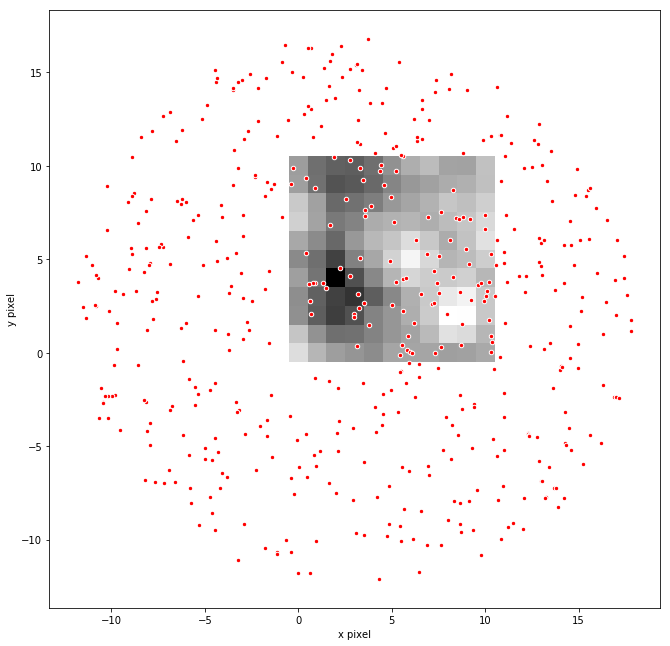

In [45]:
# get first frame of flux from TPF
data = tpf.hdulist['PIXELS'].data["FLUX"][0,:,:]

# use log image normalization
norm = simple_norm(data, 'log')

# plot with wcs or not
use_wcs = False

# plot image and overlay TIC points
ax = plt.subplot(projection=wcs if use_wcs else None)
ax.imshow(data, origin='lower', norm=norm, cmap='gray')
#ax.scatter(tic_ra, tic_dec, transform=ax.get_transform('world'), s=20, facecolor='red', edgecolor='white')
ax.scatter(xc, yc, s=20, facecolor='red', edgecolor='white')


ax.figure.set_size_inches((11,11))

# deal with axes
if use_wcs:
    xax = ax.coords[0]
    yax = ax.coords[1]
    xax.set_ticks(spacing=1.*u.arcmin)
    yax.set_ticks(spacing=0.5 * u.arcmin)
    xax.set_axislabel('Right Ascension')
    yax.set_axislabel('Declination')
else:
    ax.set_xlabel('x pixel')
    ax.set_ylabel('y pixel')

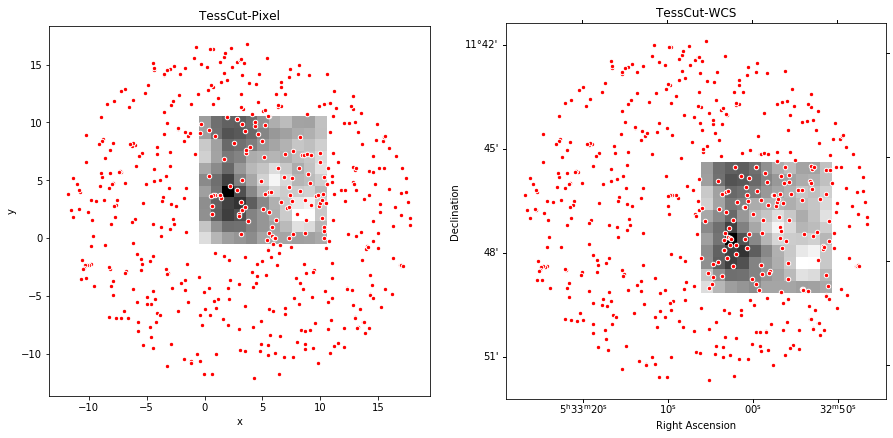

In [46]:
# Pixel plot
ax1 = plt.subplot(1,2,1)
ax1.imshow(data, origin='lower', norm=norm,  cmap='gray')
ax1.scatter(xc, yc, s=20, facecolor='red', edgecolor='white')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('TessCut-Pixel')

# WCS plot
ax2 = plt.subplot(1,2,2, projection=wcs)
ax2.imshow(data, origin='lower', norm=norm,  cmap='gray')
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel('Declination')
ax2.scatter(tic_ra, tic_dec, transform=ax2.get_transform('world'), s=20, facecolor='red', edgecolor='white')
ax2.set_title('TessCut-WCS')

ax1.figure.set_size_inches((15,15))
ax2.figure.set_size_inches((15,15))

In [47]:
url = "https://archive.stsci.edu/cgi-bin/dss_search"
plateDict = {"red": "2r", 
             "blue": "2b", 
             "ukred": "poss2ukstu_red", 
             "ukblue": "poss2ukstu_blue"}

def getdss(ra, dec, plate="red", height=None, width=None, 
           filename=None, directory=None):

    """Extract DSS image at position and write a FITS file
    
    ra, dec are J2000 coordinates in degrees
    plate can be "red", "blue", "ukred", or "ukblue"
    height and width are in arcmin, default = 7.0.  Image is square if only one is specified.
    filename specifies name for output file (default="dss_{plate}_{ra}_{dec}.fits")
    directory is location for output file (default is current directory)
    
    Returns the name of the file that was written
    """

    # set defaults for height & width
    if height is None:
        if width is not None:
            height = width
        else:
            height = 7.0
            width = 7.0
    elif width is None:
        width = height

    try:
        vplate = plateDict[plate]
    except KeyError:
        raise ValueError("Illegal plate value '{}'\nShould be one of {}".format(
            plate,', '.join(plateDict.keys())))

    # construct filename
    if filename is None:
        filename = "dss_{}_{:.6f}_{:.6f}.fits".format(plate,ra,dec)
    if directory:
        filename = os.path.join(directory, filename)

    params={"r": ra,
            "d": dec,
            "v": vplate,
            "e": "J2000",
            "h": height,
            "w": width,
            "f":"fits",
            "c":"none",
            "s": "yes"}
    r = requests.get(url, params=params)

    # read and format the output
    value = r.content
    if not r.content.startswith(b"SIMPLE  ="):
        raise ValueError("No FITS file returned for {}".format(filename))
    fhout = open(filename, "wb")
    fhout.write(r.content)
    fhout.close()
    return filename

In [48]:
# compute the pixel area in arcmin
arcmin = area.to(u.arcmin).value

# retrieve the DSS file
filename = getdss(ra, dec, height=arcmin, width=arcmin, directory=path)
print('DSS Image:', filename)

DSS Image: /Users/ewarrick/Data Work/Class II SB2s/dss_red_83.278030_11.779415.fits


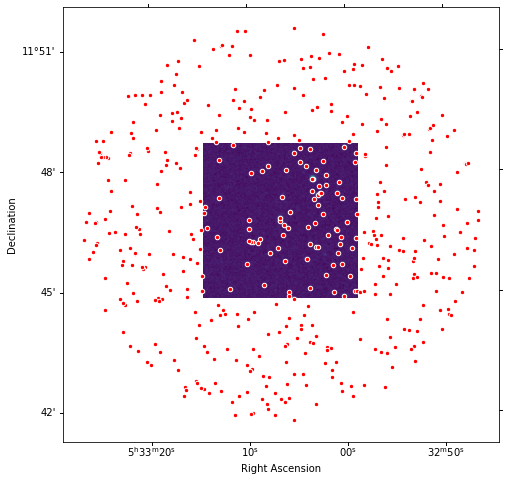

In [49]:
dss = fits.open(filename)

# get the data and WCS for the DSS image
dss_data = dss[0].data
dss_wcs = WCS(dss[0].header)

# display the DSS image and overlay the TIC objects
ax = plt.subplot(projection=dss_wcs)
ax.imshow(dss_data, origin='lower')
ax.scatter(tic_ra, tic_dec, transform=ax.get_transform('world'), s=20, facecolor='red', edgecolor='white')
ax.figure.set_size_inches((8,8))
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

In [50]:
# reproject the tesscut onto dss
reproj_tesscut, footprint = reproject_interp((data, wcs,), dss_wcs, shape_out=dss_data.shape, order='nearest-neighbor')

In [53]:
# create the function to overlay dss + tesscut + tic catalog
def create_plot(background_img, foreground_img, alpha, norm, wcs, ra, dec):
    ''' create an interactive matplotlib image plot
    
    Parameters:
        background_img (ndarray):
            The background image data to show
        foreground_img (ndarray):
            The foreground image data to overplot. 
        alpha (tuple):
            A tuple of min, max for the interactive slider.  
        norm:
            The image normalization to use for the overlaid image.
        wcs (astropy.wcs.wcs.WCS):
            The WCS of the background image
        ra (list):
            A list of RA coordinate objects
        dec (list):
            A list of Dec coordinate objects
    '''
    # create plot
    ax = plt.subplot(projection=wcs)
    ax.figure.set_size_inches((10,10))

    # show image 1
    ax.imshow(background_img, origin='lower')

    # overlay image 2
    ax.imshow(foreground_img, origin='lower', alpha=alpha, norm=norm, cmap='gray')

    # overlay a list of objects
    ax.scatter(ra, dec, transform=ax.get_transform('world'), s=20, facecolor='red', edgecolor='white')

    # add axis labels
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')

In [54]:
# create an interactive ipywidget plot for the opacity of tesscut
interactive_plot = interactive(create_plot, background_img=fixed(dss_data), foreground_img=fixed(reproj_tesscut), 
                               alpha=(0.0,1.0), norm=fixed(norm), wcs=fixed(dss_wcs), 
                               ra=fixed(tic_ra), dec=fixed(tic_dec))
# display the plot
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0), Output(layout=Layout(height='500px…